# Подготовка данных для ASR

## Импорты

In [1]:
import os
import re

import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from torch.utils.data import Dataset

from dataset_all import IPS1ASRDataset
from TatAsr.utils import clean_text

## Датасеты

In [2]:
DATASET_PATH = '../tatar_asr_3'

In [3]:
ips_dataset_train = IPS1ASRDataset(f'{DATASET_PATH}/train/')
ips_dataset_valid = IPS1ASRDataset(f'{DATASET_PATH}/valid/')

Отсутствует файл 106402_549.txt
Отсутствует файл 106402_563.txt
Отсутствует файл 106392_986.txt
Отсутствует файл 106402_1280.txt


In [4]:
print(f'len(ips_dataset_train) = {len(ips_dataset_train)}')
print(f'len(ips_dataset_valid) = {len(ips_dataset_valid)}')

len(ips_dataset_train) = 15834
len(ips_dataset_valid) = 3975


In [5]:
ips_dataset_train.get_metadata(65)

('../tatar_asr_3/train/106402_813.wav', 16000, '\ufeffКараклар, ', 0, 0, 0)

In [6]:
def from_dataset_to_df(dataset: Dataset) -> pd.DataFrame:
    data = []
    for index in range(len(dataset)):
        item = dataset.get_metadata(index)
        
        text = clean_text(item[2])
        item_dict = {
            'id': str(item[0].split('/')[-1][:-4]),
            'text': text,
            'len': len(text),
            'word_count': len(text.split()),
            'duration': dataset[index][0].shape[1] / 16_000
        }
        data.append(item_dict)
    df = pd.DataFrame(data)
    del data
    return df

In [7]:
df_train = from_dataset_to_df(ips_dataset_train)
df_valid = from_dataset_to_df(ips_dataset_valid)

In [8]:
df_train.head()

,id,text,len,word_count,duration
0,106371_705,аннары ул озак торырга ярамый әнкәйләр ачулана...,83,13,6.273000
1,106238_945,сабирҗан мәзин яисә гыймади карт монда күчеп к...,84,12,5.643187
2,106406_1618,мине сезнең колхозга вәкил итеп җибәрделәр,42,6,2.827812
3,106406_294,улым исән сау кайтсын,21,4,1.413938
4,106373_483,патша нишләргә белмичә кара кайгыга төште шашы...,53,8,5.978937


In [9]:
df_valid.head()

,id,text,len,word_count,duration
0,106392_0,аның иркен күкрәгеннән чыккан тавышы,36,5,2.639375
1,106367_2030,дип сүзгә керештеләр,20,3,1.990938
2,106392_1581,казармадан ерак түгел өем өем булып тезелеп ки...,154,22,11.626625
3,106238_50,сафа шундук хатынының фикер юнәлешен аңлап алд...,155,22,11.355313
4,106402_1371,күзләре каршыларындагы нәрсәләрне күрмәс дәрәҗ...,54,6,3.818938


In [11]:
seconds = df_train['duration'].sum() + df_valid['duration'].sum()
print(f'Продолжительность аудио в датасете (3) = {round(seconds / 3600, 2)} часов')

Продолжительность аудио в датасете (3) = 23.04 часов


## Исследование данных

### Длина текста

#### value_counts

In [12]:
df_train['len'].value_counts()

len
29     275
33     270
31     267
34     266
35     263
      ... 
189      1
243      1
627      1
286      1
250      1
Name: count, Length: 270, dtype: int64

In [13]:
df_train['word_count'].value_counts()

word_count
5     1600
6     1576
4     1561
7     1410
3     1292
8     1239
9     1000
10     874
2      859
11     727
12     581
13     471
14     430
15     345
1      335
16     264
17     244
18     191
19     149
20     121
22      86
21      74
23      59
24      56
26      39
25      33
28      25
32      25
29      23
31      20
27      19
33      18
30      18
35      12
34       9
37       7
39       5
41       5
36       5
42       5
43       4
48       4
40       3
38       2
47       2
51       2
88       1
53       1
52       1
50       1
49       1
Name: count, dtype: int64

#### Гистограммы

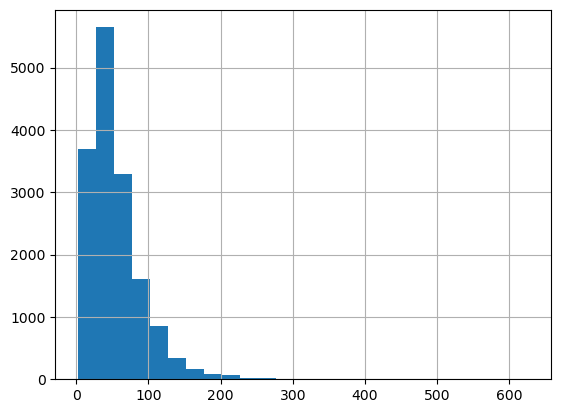

In [14]:
df_train['len'].hist(bins=25)
None

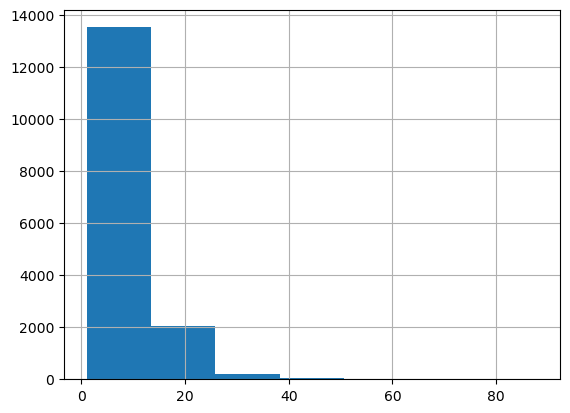

In [15]:
df_train['word_count'].hist(bins=7)
None

#### Ящик с усами

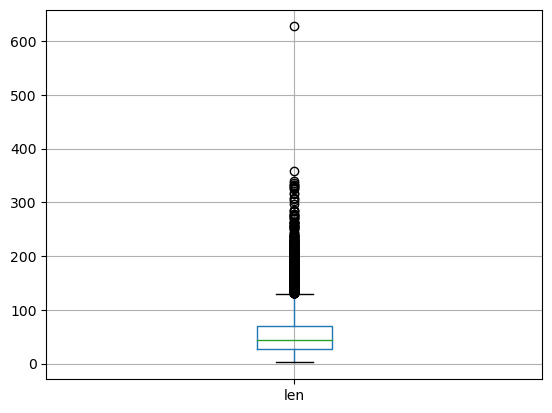

In [16]:
df_train.boxplot(column='len')
None

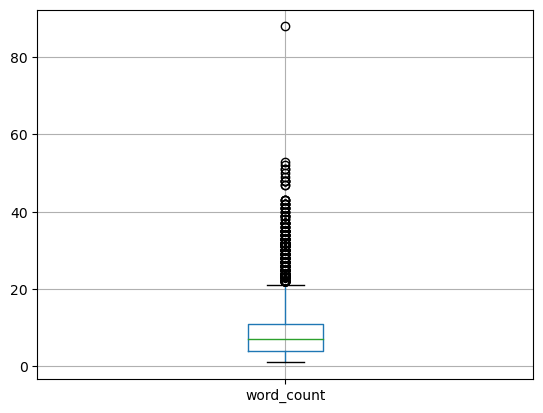

In [17]:
df_train.boxplot(column='word_count')
None

#### describe

In [18]:
df_train['word_count'].describe()

count    15834.000000
mean         8.320197
std          5.671543
min          1.000000
25%          4.000000
50%          7.000000
75%         11.000000
max         88.000000
Name: word_count, dtype: float64

In [19]:
df_train['len'].describe()

count    15834.000000
mean        53.472338
std         38.212852
min          2.000000
25%         28.000000
50%         44.000000
75%         69.000000
max        627.000000
Name: len, dtype: float64

### Вывод

In [20]:
df_train.loc[df_train['word_count'] == 1].shape[0] / df_train.shape[0] * 100

2.1157003915624606

In [21]:
# df_train.loc[(2 < df_train['len']) & (df_train['len'] < 68)].shape[0] / df_train.shape[0] * 100

Удалим 10% данных, которые являются выбросами

In [22]:
#df_train = df_train.loc[df_train['word_count'] == 1]
# df_train = df_train.loc[(2 < df_train['len']) & (df_train['len'] < 68)]

#df_valid = df_valid.loc[df_valid['word_count'] == 1]
# df_valid = df_valid.loc[(2 < df_valid['len']) & (df_valid['len'] < 68)]

In [23]:
df_train.to_csv(f'{DATASET_PATH}/train.csv')
df_valid.to_csv(f'{DATASET_PATH}/valid.csv')

### Цифры

In [24]:
def get_digits(text):
    numbers = re.findall(r'\d+', text)
    return numbers == []

In [25]:
assert get_digits('бөгелеп төшмәве') == True, 'Неверная работа функции get_digits'
assert get_digits('бөгелеп төшмәве 1') == False, 'Неверная работа функции get_digits'
assert get_digits('1 бөгелеп төшмәве 2') == False, 'Неверная работа функции get_digits'

In [26]:
df_train['numbers'] = df_train['text'].apply(lambda row: get_digits(row))
df_valid['numbers'] = df_valid['text'].apply(lambda row: get_digits(row))

In [27]:
df_train.loc[df_train['numbers'] == False].head()

,id,text,len,word_count,duration,numbers


In [28]:
df_valid.loc[df_valid['numbers'] == False].head()

,id,text,len,word_count,duration,numbers


In [24]:
df_train.loc[df_train['numbers'] == False].shape[0]

0

Найдено 33 строки в тренировочном наборе данных, в которых встречаюся числительные

### Специальные символы

In [25]:
def get_char_dijits(text):
    special_characters = '@#$%^&*()-+_=<>/\'":;[]{}\\|~`!?,.'
    for char in text:
        if char in special_characters:
            return False
    return True

In [26]:
assert get_char_dijits('бөгелеп төшмәве') == True, 'Неверная работа функции get_digits'
assert get_char_dijits('бөгелеп төшмәве ""') == False, 'Неверная работа функции get_digits'
assert get_char_dijits('1 бөгелеп төшмәве ..\\||') == False, 'Неверная работа функции get_digits'

In [27]:
df_train['char_dijits'] = df_train['text'].apply(lambda row: get_char_dijits(row))
df_valid['char_dijits'] = df_valid['text'].apply(lambda row: get_char_dijits(row))

In [28]:
df_train.loc[df_train['char_dijits'] == False].head()

,id,text,len,word_count,numbers,char_dijits


In [29]:
df_train.loc[df_train['char_dijits'] == False].shape[0]

0

In [30]:
df_valid.loc[df_valid['char_dijits'] == False].head()

,id,text,len,word_count,numbers,char_dijits


In [31]:
df_valid.loc[df_train['char_dijits'] == False].shape[0]

0

Мы разрешаем иметь в данных !?, символы. остальные нужно будет удалить из датасета